In [1]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import pandas as pd

In [2]:
ARRIVAL = 1/3  # Fixed average inter-arrival time
SIM_TIME = 200000  # Total simulation time
SERVICE_VALUES = [i for i in range(5, 41, 2)]  # Average service times: 5.0 to 40.0 in steps of 2
REPETITION = 10 # Number of repetitions for each service time
SEED_BASE = 100 #starting sedd 
TYPE1 = 1

In [3]:
class Measure:
    def __init__(self, Narr, Ndep, NAveraegUser, OldTimeEvent, AverageDelay):
        self.arr = Narr
        self.dep = Ndep
        self.ut = NAveraegUser
        self.oldT = OldTimeEvent
        self.delay = AverageDelay

In [4]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

In [5]:
def run_simulation(service_time, seed):
    global users, data, MM1
    users = 0
    data = Measure(0, 0, 0, 0, 0)
    MM1 = []
    time = 0
    FES = PriorityQueue()
    busy_time = 0

    def arrival(current_time):
        global users
        nonlocal busy_time
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time
        inter_arrival = random.expovariate(1.0 / ARRIVAL)
        FES.put((current_time + inter_arrival, "arrival"))
        users += 1
        client = Client(TYPE1, current_time)
        MM1.append(client)
        if users == 1:
            currentservice_time = random.expovariate(1/service_time)
            busy_time += currentservice_time
            FES.put((current_time + currentservice_time, "departure"))

    def departure(current_time):
        global users
        nonlocal busy_time
        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time
        client = MM1.pop(0)
        data.delay += (current_time - client.arrival_time)
        users -= 1
        if users > 0:
            currentservice_time = random.expovariate(1/service_time)
            busy_time += currentservice_time
            FES.put((current_time + currentservice_time, "departure"))

    random.seed(seed)
    FES.put((0.0, "arrival"))
    while time < SIM_TIME:
        time, event_type = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure":
            departure(time)

    avg_delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time if time > 0 else 0
    utilization = busy_time / time if time > 0 else 0
    return avg_delay, avg_users, utilization

# Run repetitions for each service rate and collect confidence intervals
results = []

for servicetime in SERVICE_VALUES:
    delays, user_list, utilist = [], [], []

    # reapeat with varying seeds
    for i in range(REPETITION):
        delay, avg_users,utilization  = run_simulation(1/servicetime, SEED_BASE + i)
        delays.append(delay)
        user_list.append(avg_users)
        utilist.append(utilization)

    
    mean_delay = np.mean(delays)
    sem = stats.sem(delays)
    t_score = stats.t.ppf(0.975, len(delays) - 1)  # 95% CI
    margin = t_score * sem # margin of error

    ci_lower = mean_delay - margin
    ci_upper = mean_delay + margin

    results.append({
        "Service Rate (μ)": round(servicetime, 4),
        "Avg Delay": mean_delay,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
        "Margin of Error": margin,
        "Avg users" : np.mean(user_list),
        "Utilization": np.mean(utilist)
    })
  

In [6]:
# Display result as a table
df_results = pd.DataFrame(results)
print("\nTask 1.b - Average Delay with 95% Confidence Intervals")
print(df_results)



Task 1.b - Average Delay with 95% Confidence Intervals
    Service Rate (μ)  Avg Delay  95% CI Lower  95% CI Upper  Margin of Error  \
0                  5   0.500805      0.498543      0.503068         0.002263   
1                  7   0.250367      0.249568      0.251167         0.000799   
2                  9   0.166887      0.166505      0.167268         0.000381   
3                 11   0.125148      0.124904      0.125391         0.000243   
4                 13   0.100135      0.099969      0.100302         0.000166   
5                 15   0.083455      0.083336      0.083573         0.000118   
6                 17   0.071519      0.071445      0.071592         0.000073   
7                 19   0.062574      0.062516      0.062632         0.000058   
8                 21   0.055614      0.055556      0.055672         0.000058   
9                 23   0.050054      0.050006      0.050102         0.000048   
10                25   0.045497      0.045457      0.045537     

In [7]:
# Plot results with error bars
plt.figure(figsize=(8, 5))
mu_vals = df_results["Service Rate (μ)"]
avg = df_results["Avg Delay"]
err = df_results["Margin of Error"]

<Figure size 800x500 with 0 Axes>

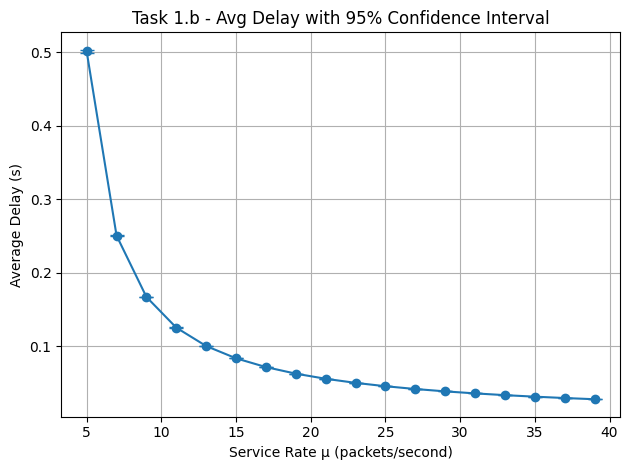

In [8]:
plt.errorbar(mu_vals, avg, yerr=err, fmt='o-', capsize=5)
plt.xlabel("Service Rate μ (packets/second)")
plt.ylabel("Average Delay (s)")
plt.title("Task 1.b - Avg Delay with 95% Confidence Interval")
plt.grid(True)
plt.tight_layout()
plt.show()

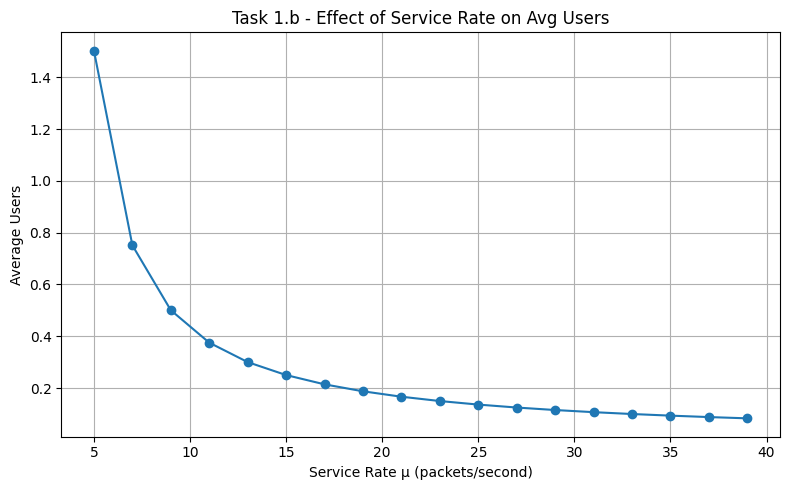

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(mu_vals, df_results["Avg users"], marker='o')
plt.xlabel("Service Rate μ (packets/second)")
plt.ylabel("Average Users")
plt.title("Task 1.b - Effect of Service Rate on Avg Users")
plt.grid(True)
plt.tight_layout()
plt.show()

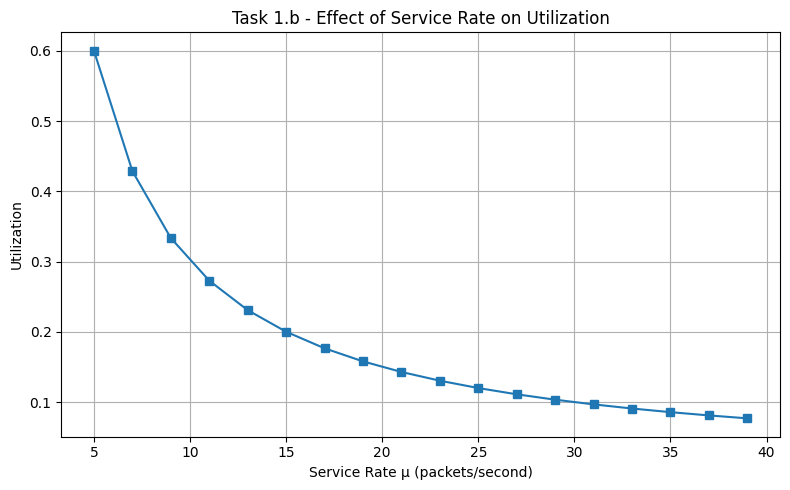

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(mu_vals, df_results["Utilization"], marker='s')
plt.xlabel("Service Rate μ (packets/second)")
plt.ylabel("Utilization")
plt.title("Task 1.b - Effect of Service Rate on Utilization")
plt.grid(True)
plt.tight_layout()
plt.show()